# Copyright Netherlands eScience Center <br>
** Function     : Paper Figure - OMET in reanalyses and RAPID ** <br>
** Author       : Yang Liu ** <br>
** First Built  : 2019.03.15 ** <br>
** Last Update  : 2019.03.15 ** <br>
Description     : This script serves to prepare figures for the paper about the Bjerknes compensation in the subpolar region. It compares OMET from reanalyses and OSNAP at approximately 60N.<br>

Return Values   : png <br>
Caveat!         : N/A<br>

In [1]:
%matplotlib inline

import sys
sys.path.append("/home/ESLT0068/NLeSC/Computation_Modeling/Bjerknes/Scripts/META")
import numpy as np
import scipy
from netCDF4 import Dataset
import matplotlib
import matplotlib.pyplot as plt
import os
import meta.statistics
import meta.visualizer
from scipy import stats
import cartopy.crs as ccrs

Initialization - Start with location of input and extraction of variables
Time span of each product:
- **ERA-Interim** 1979 - 2016
- **MERRA2**      1980 - 2016
- **JRA55**       1979 - 2015
- **ORAS4**       1958 - 2017
- **GLORYS2V3**   1993 - 2014
- **SODA3**       1980 - 2015

In [2]:
# constants
constant = {'g' : 9.80616,      # gravititional acceleration [m / s2]
            'R' : 6371009,      # radius of the earth [m]
            'cp': 1004.64,      # heat capacity of air [J/(Kg*K)]
            'Lv': 2264670,      # Latent heat of vaporization [J/Kg]
            'R_dry' : 286.9,    # gas constant of dry air [J/(kg*K)]
            'R_vap' : 461.5,    # gas constant for water vapour [J/(kg*K)]
            'HoF' : 334,        # heat of fusion of ice [KJ/Kg] 
            'rho_ice' : 0.91    # density of sea ice [g/cm3]
            }

In [3]:
print ('****************************************************************************')
print ('********************    latitude index of insteret     *********************')
print ('****************************************************************************')
# 60N
lat_ORAS4_60 = 233
lat_GLORYS2V3_60 = 788
lat_SODA3_60 = 789
# after a cut to 20-90 N
lat_ORAS4_60_cut = 53
lat_GLORYS2V3_60_cut = 209
lat_SODA3_60_cut = 220

****************************************************************************
********************    latitude index of insteret     *********************
****************************************************************************


In [4]:
if __name__=="__main__":
    # sample
    ################################   Input zone  ######################################
    # specify data path
    # OMET
    datapath_ORAS4 = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/warehouse_met'
    datapath_GLORYS2V3 = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/GLORYS2V3/postprocessing'
    datapath_SODA3 = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/SODA3/postprocessing'
    datapath_RAPID = '/home/ESLT0068/NLeSC/Computation_Modeling/BlueAction/Oceanography/RAPID_ARRAY'
    datapath_hindcast = '/home/ESLT0068/NLeSC/Computation_Modeling/BlueAction/Oceanography/ORCA083hindcast_BenMoat'
    # mask
    datapath_mask_ORAS4 ='/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/ORAS4'
    datapath_mask_GLORYS2V3 ='/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/GLORYS2V3'
    datapath_mask_SODA3 ='/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/SODA3'
    
    output_path = '/home/ESLT0068/NLeSC/PhD/Paperwork/Article/AMET_OMET/ESD/figures/'
    #####################################################################################
    print ('*********************** extract variables *************************')
    dataset_ORAS4_point = Dataset(os.path.join(datapath_ORAS4,
                                              'oras_model_monthly_1958_2017_omet.nc'))
    dataset_GLORYS2V3_point = Dataset(datapath_GLORYS2V3 + os.sep + 'GLORYS2V3_model_monthly_orca025_E_point.nc')
    dataset_SODA3_point = Dataset(os.path.join(datapath_SODA3,
                                               'OMET_SODA3_model_5daily_1980_2015_E_point.nc'))
    dataset_mask_ORAS4 = Dataset(datapath_mask_ORAS4 + os.sep + 'mesh_mask.nc')
    dataset_mask_GLORYS2V3 = Dataset(datapath_mask_GLORYS2V3 + os.sep + 'G2V3_mesh_mask_myocean.nc')
    dataset_mask_SODA3 = Dataset(datapath_mask_SODA3 + os.sep + 'topog.nc')
    
    dataset_RAPID = Dataset(datapath_RAPID + os.sep + 'mocha_mht_data_2015.nc')
    dataset_hindcast = Dataset(datapath_hindcast + os.sep + 'OMET_psi_hindcast_ORCA083_1958-2012_Atlantic_2605.nc')
    # extract time series
    # from 20N - 90N
    #OMET_ORAS4 = dataset_ORAS4_OMET.variables['E_int'][21:-1,:,180:]/1000 # from Tera Watt to Peta Watt # start from 1979
    #OMET_SODA3 = dataset_SODA3_OMET.variables['E'][:,:,569:]/1000
    
    OMET_ORAS4 = dataset_ORAS4_point.variables['E_total'][46:-2,:,:,:]/1E+3     # from 2004 to 2015
    OMET_GLORYS2V3 = dataset_GLORYS2V3_point.variables['E'][11:,:,:,:]/1E+3  # from 2004
    OMET_SODA3 = dataset_SODA3_point.variables['E'][24:,:,:,:]/1E+3  # from 2004
    # dimensions info
    # time
    year_ORAS4 = dataset_ORAS4_point.variables['year'][46:-2]
    year_GLORYS2V3 = dataset_GLORYS2V3_point.variables['year'][11:]     # from 2004
    year_SODA3 = dataset_SODA3_point.variables['year'][24:]
    # latitude
    lat_ORAS4_ORCA = dataset_ORAS4_point.variables['gphiv'][:]
    lat_GLORYS2V3_ORCA = dataset_GLORYS2V3_point.variables['latitude'][:]
    lat_SODA3_MOM = dataset_SODA3_point.variables['latitude'][:]
    # longitude
    lon_ORAS4_ORCA = dataset_ORAS4_point.variables['glamv'][:]
    lon_GLORYS2V3_ORCA = dataset_GLORYS2V3_point.variables['longitude'][:]
    lon_SODA3_MOM = dataset_SODA3_point.variables['longitude'][:]
    # mask
    mask_ORAS4 = dataset_mask_ORAS4.variables['vmask'][0,0,:,:]
    mask_GLORYS2V3 = dataset_mask_GLORYS2V3.variables['vmask'][0,0,:,:]
    mask_SODA3 = dataset_mask_SODA3.variables['wet_c'][:]

    # hindcast
    # meridional energy transport
    OMET_hindcast = dataset_hindcast.variables['E'][:]

    # observation
    # RAPID ARRAY
    # meridional energy transport
    OMET_RAPID = dataset_RAPID.variables['Q_sum'][:]/1E+15
    month_RAPID = dataset_RAPID.variables['month'][:]
    year_RAPID = dataset_RAPID.variables['year'][:]
    OMET_RAPID_monthly = np.zeros(139,dtype=float) # 12*12-3-2
    pool_sum = 0.0000000000001 # start with a float value
    month_counter = 4 # starts from April
    index_array = 0
    counter = 0
    for i in np.arange(len(month_RAPID)):
        if i == len(month_RAPID)-1:
            OMET_RAPID_monthly[index_array] = pool_sum / counter
            print ('Obtain all the monthly mean of OMET from RAPID!')
        elif  month_counter == month_RAPID[i]:
            pool_sum = pool_sum + OMET_RAPID[i]
            counter = counter + 1
        else :
            # take the mean of the measurements for the current month
            OMET_RAPID_monthly[index_array] = pool_sum / counter
            pool_sum = OMET_RAPID[i] # reset summation
            month_counter = month_RAPID[i] # update the month_counter
            index_array = index_array + 1  # update the array counter
            counter = 1 # reset counter

*********************** extract variables *************************
Obtain all the monthly mean of OMET from RAPID!


In [5]:
    print ('*********************** Locations on Curvilinear Grid *************************')
    # ORCA1 (ORAS4)
    # ii jj pairs of locations on ORCA grid for comparison with observcation
    # for RAPID ARRAY
    # ORCA1 (ORAS4)
    ii_ORCA1_RAPID = np.arange(207,274,1,dtype=int) # from 207 to 273
    jj_ORCA1_RAPID = np.array([188,188,188,188,188,
                               188,188,188,188,188,
                               188,188,188,188,188,
                               188,188,188,188,188,
                               187,187,187,187,187,
                               187,187,187,187,187,
                               187,187,187,186,186,
                               186,186,185,185,185,
                               185,185,185,185,185,
                               185,185,185,185,185,
                               185,185,185,185,185,
                               185,185,185,186,186,
                               186,187,187,188,188,
                               189,189], dtype=int)
    # ORCA025(GLORYS2V3)
    ii_ORCA025_RAPID = np.arange(828,1092,1,dtype=int) # from 828 to 1091
    jj_ORCA025_RAPID = np.array([606,606,606,606,606,
                           606,606,606,606,605,
                           605,605,605,605,605,
                           605,605,605,605,605,
                           605,605,605,606,606,
                           606,606,606,606,606,
                           606,606,606,606,606,
                           606,606,606,606,606,
                           606,606,606,606,606,
                           606,606,606,606,606,
                           606,606,606,606,605,
                           605,605,605,605,605,
                           605,605,605,605,605,
                           605,605,605,605,605,
                           605,605,605,605,605,
                           604,604,604,604,604,
                           604,604,604,604,604,
                           604,604,604,604,604,
                           604,604,604,604,604,
                           604,603,603,603,603,
                           603,603,603,603,603,
                           603,603,603,603,603,
                           603,603,603,603,603,
                           603,603,603,603,603,
                           603,603,602,602,602,
                           602,601,601,601,601,
                           600,600,600,600,599,
                           599,599,598,598,598,
                           597,597,597,596,596,
                           596,596,595,595,595,
                           595,594,594,594,594,
                           594,594,594,594,594,
                           594,594,594,594,594,
                           594,594,594,594,594,
                           594,594,594,594,594,
                           594,594,594,594,594,
                           594,594,594,594,594,
                           594,594,594,594,594,
                           594,594,594,594,594,
                           594,594,594,594,594,
                           594,594,594,594,594,
                           594,594,594,594,594,
                           594,594,594,594,594,
                           594,594,594,594,594,
                           594,594,594,594,595,
                           595,596,597,598,599,
                           599,600,600,600,600,
                           600,601,601,602,602,
                           602,603,603,603,604,
                           604,604,605,605,606,
                           606,607,607,607,607,
                           607,608,608,609,610,
                           611,612,612,612], dtype=int)
    # MOM5(SODA3)
    ii_MOM5_RAPID = np.arange(799,1063,1,dtype=int) # from 799 to 1062
    jj_MOM5_RAPID = np.array([594,594,594,594,594,
                          594,594,594,594,595,
                          595,595,595,595,595,
                          595,595,595,595,595,
                          595,595,595,596,596,
                          596,596,596,596,596,
                          596,596,596,596,596,
                          596,596,596,596,596,
                          596,596,596,596,596,
                          596,596,596,596,596,
                          596,596,596,596,595,
                          595,595,595,595,595,
                          595,595,595,595,595,
                          595,595,595,595,595,
                          595,595,595,595,595,
                          594,594,594,594,594,
                          594,594,594,594,594,
                          594,594,594,594,594,
                          594,594,594,594,594,
                          594,593,593,593,593,
                          593,593,593,593,593,
                          593,592,592,592,592,
                          592,592,592,592,592,
                          592,592,592,592,592,
                          592,592,591,591,591,
                          591,591,590,590,590,
                          590,590,589,589,589,
                          588,588,588,587,587,
                          587,586,586,586,586,
                          586,585,585,585,585,
                          585,584,584,584,584,
                          584,584,584,584,584,
                          584,584,584,584,584,
                          584,584,584,584,584,
                          584,584,584,584,584,
                          584,584,584,584,584,
                          584,584,584,584,584,
                          584,584,584,584,584,
                          584,584,584,584,584,
                          584,584,584,584,584,
                          584,584,584,584,584,
                          584,584,584,584,584,
                          584,584,584,584,584,
                          584,584,584,584,584,
                          584,584,584,584,585,
                          585,586,587,588,588,
                          588,589,589,589,589,
                          589,589,590,590,591,
                          591,592,592,593,594,
                          594,595,595,596,596,
                          597,597,597,597,598,
                          598,598,599,599,599,
                          600,600,600,601], dtype=int)

*********************** Locations on Curvilinear Grid *************************


In [6]:
# construct the matrix
OMET_ORAS4_RAPID = np.zeros((len(year_ORAS4),12,len(ii_ORCA1_RAPID)),dtype= float)
OMET_GLORYS2V3_RAPID = np.zeros((len(year_GLORYS2V3),12,len(ii_ORCA025_RAPID)),dtype= float)
OMET_SODA3_RAPID = np.zeros((len(year_SODA3),12,len(ii_MOM5_RAPID)),dtype= float)

for i in np.arange(len(year_ORAS4)):
    for j in np.arange(12):
        for k in np.arange(len(ii_ORCA1_RAPID)):
            OMET_ORAS4_RAPID[i,j,k] = OMET_ORAS4[i,j,jj_ORCA1_RAPID[k],ii_ORCA1_RAPID[k]] \
                                      * mask_ORAS4[jj_ORCA1_RAPID[k],ii_ORCA1_RAPID[k]]

for i in np.arange(len(year_GLORYS2V3)):
    for j in np.arange(12):
        for k in np.arange(len(ii_ORCA025_RAPID)):
            OMET_GLORYS2V3_RAPID[i,j,k] = OMET_GLORYS2V3[i,j,jj_ORCA025_RAPID[k],ii_ORCA025_RAPID[k]] \
                                          * mask_GLORYS2V3[jj_ORCA025_RAPID[k],ii_ORCA025_RAPID[k]]

for i in np.arange(len(year_SODA3)):
    for j in np.arange(12):
        for k in np.arange(len(ii_MOM5_RAPID)):
            OMET_SODA3_RAPID[i,j,k] = OMET_SODA3[i,j,jj_MOM5_RAPID[k],ii_MOM5_RAPID[k]] \
                                          * mask_SODA3[jj_MOM5_RAPID[k],ii_MOM5_RAPID[k]]
# take the zonal integral
OMET_ORAS4_RAPID_int = np.sum(OMET_ORAS4_RAPID,2)
OMET_GLORYS2V3_RAPID_int = np.sum(OMET_GLORYS2V3_RAPID,2)
OMET_SODA3_RAPID_int = np.sum(OMET_SODA3_RAPID,2)
# reshape to get the time series
OMET_ORAS4_RAPID_series = OMET_ORAS4_RAPID_int.reshape(len(year_ORAS4)*12)
OMET_GLORYS2V3_RAPID_series = OMET_GLORYS2V3_RAPID_int.reshape(len(year_GLORYS2V3)*12)
OMET_SODA3_RAPID_series = OMET_SODA3_RAPID_int.reshape(len(year_SODA3)*12)
# reshape the hindcast dataset
OMET_hindcast_series = OMET_hindcast.reshape(55*12)

In [7]:
# calculate the standard deviation of OMET anomaly
# RAPID
OMET_RAPID_std = np.std(OMET_RAPID_monthly)
print ('The standard deviation of OMET from RAPID is (in peta Watt):')
print (OMET_RAPID_std)
# GLORYS2V3
OMET_GLORYS2V3_std = np.std(OMET_GLORYS2V3_RAPID_series)
print ('The standard deviation of OMET from GLORYS2V3 is (in peta Watt):')
print (OMET_GLORYS2V3_std)
# ORAS4
OMET_ORAS4_std = np.std(OMET_ORAS4_RAPID_series)
print ('The standard deviation of OMET from ORAS4 is (in peta Watt):')
print (OMET_ORAS4_std)
# SODA3
OMET_SODA3_std = np.std(OMET_SODA3_RAPID_series)
print ('The standard deviation of OMET from SODA3 is (in peta Watt):')
print (OMET_SODA3_std)
# NEMO
OMET_NEMO_std = np.std(OMET_hindcast_series)
print ('The standard deviation of OMET from NEMO is (in peta Watt):')
print (OMET_NEMO_std)

The standard deviation of OMET from RAPID is (in peta Watt):
0.26733064245647203
The standard deviation of OMET from GLORYS2V3 is (in peta Watt):
0.5223906128511222
The standard deviation of OMET from ORAS4 is (in peta Watt):
0.2685709840847251
The standard deviation of OMET from SODA3 is (in peta Watt):
0.5170851376014346
The standard deviation of OMET from NEMO is (in peta Watt):
0.21478644014753775


In [8]:
# calculate the mean of OMET anomaly
# RAPID
OMET_RAPID_mean = np.mean(OMET_RAPID_monthly)
print ('The mean of OMET from RAPID is (in peta Watt):')
print (OMET_RAPID_mean)
# GLORYS2V3
OMET_GLORYS2V3_mean = np.mean(OMET_GLORYS2V3_RAPID_series)
print ('The mean of OMET from GLORYS2V3 is (in peta Watt):')
print (OMET_GLORYS2V3_mean)
# ORAS4
OMET_ORAS4_mean = np.mean(OMET_ORAS4_RAPID_series)
print ('The mean of OMET from ORAS4 is (in peta Watt):')
print (OMET_ORAS4_mean)
# SODA3
OMET_SODA3_mean = np.mean(OMET_SODA3_RAPID_series)
print ('The mean of OMET from SODA3 is (in peta Watt):')
print (OMET_SODA3_mean)
# NEMO
OMET_NEMO_mean = np.mean(OMET_hindcast_series)
print ('The mean of OMET from NEMO is (in peta Watt):')
print (OMET_NEMO_mean)

The mean of OMET from RAPID is (in peta Watt):
1.2134974421134994
The mean of OMET from GLORYS2V3 is (in peta Watt):
0.888530668949506
The mean of OMET from ORAS4 is (in peta Watt):
0.6615832602454995
The mean of OMET from SODA3 is (in peta Watt):
0.8135030242737247
The mean of OMET from NEMO is (in peta Watt):
1.0485754419696969


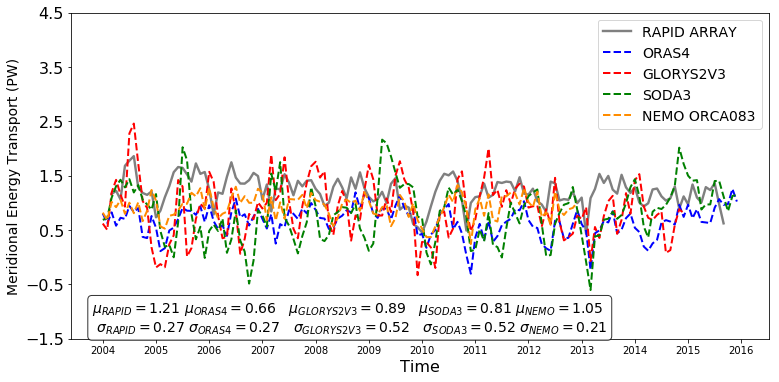

In [20]:
# index for axis
index = np.arange(1,12*12+1,1) # 2004 - 2015
#index_RAPID_hourly = np.linspace(4,12*12-3,8398) # ignore the missing April 1st 2004 and the rest of the days in Oct 2015
index_RAPID_monthly = np.arange(3,len(OMET_RAPID_monthly)+3,1)
index_hindcast = np.arange(1,12*9+1,1) # 2004 - 2012

text_content = '$\mu_{RAPID}=%.2f$ $\mu_{ORAS4}=%.2f$   $\mu_{GLORYS2V3}=%.2f$   $\mu_{SODA3}=%.2f$ $\mu_{NEMO}=%.2f$ \n $\sigma_{RAPID}=%.2f$ $\sigma_{ORAS4}=%.2f$   $\sigma_{GLORYS2V3}=%.2f$   $\sigma_{SODA3}=%.2f$ $\sigma_{NEMO}=%.2f$' \
                % (OMET_RAPID_mean, OMET_ORAS4_mean, OMET_GLORYS2V3_mean, OMET_SODA3_mean, OMET_NEMO_mean, OMET_RAPID_std, OMET_ORAS4_std, OMET_GLORYS2V3_std, OMET_SODA3_std, OMET_NEMO_std)

# meridional energy transport with hindcast on ORCA083
fig4 = plt.figure()
#plt.plot(index_RAPID[:],OMET_RAPID[:-23],color='gray',linestyle='-',linewidth=1.4,label='RAPID ARRAY')
plt.plot(index_RAPID_monthly[:],OMET_RAPID_monthly[:],color='gray',linestyle='-',linewidth=2.4,label='RAPID ARRAY')
plt.plot(index[:],OMET_ORAS4_RAPID_series[:],'b--',linewidth=2.0,label='ORAS4')
plt.plot(index[:-12],OMET_GLORYS2V3_RAPID_series[:],'r--',linewidth=2.0,label='GLORYS2V3')
plt.plot(index,OMET_SODA3_RAPID_series[:],'g--',linewidth=2.0,label='SODA3')
plt.plot(index_hindcast[:],OMET_hindcast_series[46*12:],color='darkorange',linestyle='--',linewidth=2.0,label='NEMO ORCA083')
#plt.title('Meridional Energy Transport in the ocean at 26.5 N (02/04/2004 - 12/10/2015)')
plt.legend(frameon=True, loc=1, prop={'size': 14})
fig4.set_size_inches(12.5, 6)
plt.xlabel("Time",fontsize = 16)
plt.xticks(np.linspace(1, 12*12+1, 13), np.arange(2004,2017,1))
#plt.xticks(rotation=60)
plt.ylabel("Meridional Energy Transport (PW)",fontsize = 14)
plt.yticks(np.arange(-1.5,5.0,1.0),fontsize=16)
props = dict(boxstyle='round',facecolor='white', alpha=0.8)
ax = plt.gca()
ax.text(0.03,0.12,text_content,transform=ax.transAxes,fontsize=14,verticalalignment='top',bbox=props)
plt.show()
fig4.savefig(output_path + os.sep + 'Comp_OMET_26.5N_RAPID_hindcast_time_series.jpg', dpi = 300)